### <font color='red'> Includes and network parameters</font>

In [218]:
import time
import shutil
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [219]:
# Network parameters
'''
num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
activations : TYPE, option list where each element can be either 'relu' or 'sigmoid' or 'tanh'
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(activations) should be equal to the number of hidden layers.
'''
num_neurons = [2,20,10,10,2] # list of neurons in each layer of NN. 
activations = ['relu'] # represents the activation function used at the hidden layers.

# optimizer parameters
lr = 0.01
lr_step = [500]
weight_decay = 1e-3

#  training parameters
num_epochs = 200
batch_size = 256

# 
print_freq = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### <font color='red'>Create and plot data set</font>

Do not change this cell!

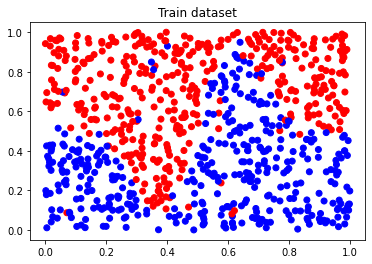

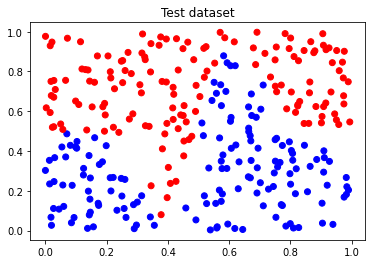

In [220]:
# DO NOT change this cell.
ns = 800
np.random.seed(0)
X_train = np.random.rand(ns,2)
x1 = X_train[:,0]
x2 = X_train[:,1]
y_train = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

idx = np.random.choice(range(ns),size=(int(ns*0.03),))
y_train[idx] = ~y_train[idx]

ns = 300
np.random.seed(1)
X_val = np.random.rand(ns,2)
x1 = X_val[:,0]
x2 = X_val[:,1]
y_val = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

def plot(X,y,title="Dataset"):
    colors = np.where(y==0, 'r', 'b')
    plt.figure()
    plt.scatter(X[:,0],X[:,1],color=colors)
    plt.title(title)
    plt.show()

plot(X_train,y_train,"Train dataset")
plot(X_val,y_val,"Test dataset")

### <font color='red'>Load data set into Torch dataloader</font>

In [221]:
X_train_tensor = torch.Tensor(X_train) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

X_val_tensor = torch.Tensor(X_val) # transform to torch tensor
y_val_tensor = torch.Tensor(y_val)

val_dataset = TensorDataset(X_val_tensor,y_val_tensor) # create your datset
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

### <font color='red'>Model: Feedforward neural network</font>

In [222]:
class LinearNN(nn.Module):
    
    def __init__(self,num_neurons,activations=['relu']):
        '''
        Parameters
        ----------
        num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
            
        activations : TYPE, optional list.
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(actiavtions) should be equal to the number of hidden layers.

        Returns
        -------
        None.

        '''
        
        super(LinearNN,self).__init__()
        assert isinstance(num_neurons,list)
        assert np.all([isinstance(neurons,int) for neurons in num_neurons])
        assert np.all([neurons>=1 for neurons in num_neurons])
        assert len(num_neurons)>=3 
        if activations is not None:
            assert isinstance(activations,(list))
            assert (len(activations)==len(num_neurons)-2) or (len(activations)==1)
        
        
        def activation_layer(act_func):
            '''
            

            Parameters
            ----------
            act_func : TYPE should be one from {'relu','sigmoid','tanh'}.
                DESCRIPTION.

            Raises
            ------
            NotImplementedError
                DESCRIPTION.

            Returns
            -------
            TYPE
                DESCRIPTION.

            '''
            if act_func=='relu':
                return nn.ReLU(inplace=True)
            elif act_func=='sigmoid':
                return nn.Sigmoid()
            elif act_func=='tanh':
                return nn.Tanh()
            else:
                raise NotImplementedError
                
        
        layers = []
        for idx,_ in enumerate(num_neurons[:-1]):
            layers.append(nn.Linear(in_features=num_neurons[idx],
                                    out_features=num_neurons[idx+1],
                                    bias=True))
            
            if idx!=len(num_neurons)-2: # add activation for all layers except the last layer.
                if len(activations)==1:
                    layers.append(activation_layer(activations[0]))
                else:
                    layers.append(activation_layer(activations[idx]))
                
        self.network = nn.Sequential(*layers)
            
    
    def forward(self,x):
        x = self.network(x)
        return x

    
def linear_nn(num_neurons,activations=['relu']):
    model = LinearNN(num_neurons,activations)
    return model


### <font color='red'>Define training function</font>

In [223]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input_var = torch.autograd.Variable(input).to(device)
        target_var = torch.autograd.Variable(target).to(device)
        # target_var = torch.squeeze(target_var)
        # compute output
        output = model(input_var)
        
        # compute loss
        loss = criterion(output, target_var.long())

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            curr_lr = optimizer.param_groups[0]['lr']
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'LR: {4}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Train Acc {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, num_epochs, i, len(train_loader), curr_lr,
                   loss=losses, top1=top1))
            
    epoch_list.append(epoch)
    lr_list.append(curr_lr)
    loss_list.append(losses.avg)
    acc_list.append(top1.avg)

    print(' * Train Acc {top1.avg:.3f}'.format(top1=top1))

### <font color='red'>Define validation and prediction functions</a>

In [224]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input_var = torch.autograd.Variable(input, volatile=True).to(device)
        target_var = torch.autograd.Variable(target, volatile=True).to(device)

        # compute output
        output = model(input_var)
        # loss = criterion(output, target_var[:,None])
        loss = criterion(output, target_var.long())
        
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), loss=losses,
                   top1=top1))
            
    val_acc_list.append(top1.avg)
    test_acc_list.append(top1.avg)

    print(' * Test Acc {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

def predict(dataloader,model):
    y_pred = []
    y_true = []
    x = []
    with torch.no_grad():
        for i, (input, target) in enumerate(dataloader):
            # target = target.to(device)
            input_var = torch.autograd.Variable(input, volatile=True).to(device)
            # target_var = torch.autograd.Variable(target, volatile=True).to(device)
    
            # compute output
            output = model(input_var)
            labels = torch.argmax(output,axis=1)
            y_pred.extend(list(labels.data.detach().cpu().numpy()))
            y_true.extend(list(target.numpy()))
            x.extend(list(input_var.data.detach().cpu().numpy()))
    return np.array(x),np.array(y_true),np.array(y_pred)



### <font color='red'>Function to plot the decision boundary of the neural network</font>

In [225]:
def plot_decision_boundary(model):
    h = 0.005
    x_min, x_max = 0,1
    y_min, y_max = 0,1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    x1 = xx.ravel()
    x2 = yy.ravel()
    y = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    
    X_train_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]) # transform to torch tensor
    y_train_tensor = torch.Tensor(y)
    
    dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False,drop_last=False)

    
    x,y_true,y_pred = predict(dataloader,model)
    Z = y_pred.reshape(xx.shape)
    plt.figure()
    plt.contourf(x[:,0].reshape(xx.shape), x[:,1].reshape(xx.shape), Z, cmap=plt.cm.Paired)
    plt.axis('tight')
    
    # scatter plot of data points with colors corresponding to the correct labels. 
    ns = 500
    np.random.seed(0)
    X_test = np.random.rand(ns,2)
    x1 = X_test[:,0]
    x2 = X_test[:,1]
    y_test = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    colors = np.where(y_test==0, 'r', 'b')
    plt.scatter(x1,x2,color=colors)
    # plt.scatter(x[:,0],x[:,1],colors=)
    plt.show()

### <font color='red'>Functions to track the model performance and save the desired model state</font>

In [226]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### <font color='red'>Create model instance; define loss function and optimizer</font> 

In [227]:
torch.manual_seed(999)
model = linear_nn(num_neurons,activations).to(device)

# define loss function (criterion) and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device) 
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    

### <font color='red'>Train model and validate</font>

Epoch: [0/200][0/4]	LR: 0.01	Loss 0.6985 (0.6985)	Train Acc 51.562 (51.562)
 * Train Acc 52.750
Test: [0/2]	Loss 0.6820 (0.6820)	Prec@1 83.594 (83.594)
 * Test Acc 83.000
-----------------------------------------------


C:\Users\Linds\AppData\Local\Temp\ipykernel_43744\3241257704.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)
C:\Users\Linds\AppData\Local\Temp\ipykernel_43744\3241257704.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True).to(device)
C:\Users\Linds\AppData\Local\Temp\ipykernel_43744\3241257704.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)


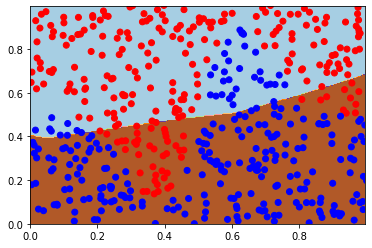

Epoch: [1/200][0/4]	LR: 0.01	Loss 0.6831 (0.6831)	Train Acc 81.250 (81.250)
 * Train Acc 78.250
Test: [0/2]	Loss 0.6595 (0.6595)	Prec@1 77.344 (77.344)
 * Test Acc 75.333
-----------------------------------------------
Epoch: [2/200][0/4]	LR: 0.01	Loss 0.6630 (0.6630)	Train Acc 73.047 (73.047)
 * Train Acc 75.875
Test: [0/2]	Loss 0.6293 (0.6293)	Prec@1 78.125 (78.125)
 * Test Acc 78.667
-----------------------------------------------
Epoch: [3/200][0/4]	LR: 0.01	Loss 0.6298 (0.6298)	Train Acc 74.609 (74.609)
 * Train Acc 76.500
Test: [0/2]	Loss 0.5832 (0.5832)	Prec@1 77.344 (77.344)
 * Test Acc 78.333
-----------------------------------------------
Epoch: [4/200][0/4]	LR: 0.01	Loss 0.5832 (0.5832)	Train Acc 75.000 (75.000)
 * Train Acc 76.500
Test: [0/2]	Loss 0.5181 (0.5181)	Prec@1 79.688 (79.688)
 * Test Acc 80.333
-----------------------------------------------
Epoch: [5/200][0/4]	LR: 0.01	Loss 0.5337 (0.5337)	Train Acc 75.781 (75.781)
 * Train Acc 77.625
Test: [0/2]	Loss 0.4754 (0.4

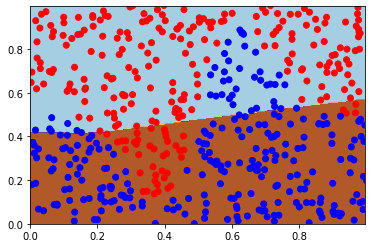

Epoch: [11/200][0/4]	LR: 0.01	Loss 0.4563 (0.4563)	Train Acc 82.031 (82.031)
 * Train Acc 81.625
Test: [0/2]	Loss 0.3819 (0.3819)	Prec@1 84.375 (84.375)
 * Test Acc 86.333
-----------------------------------------------
Epoch: [12/200][0/4]	LR: 0.01	Loss 0.4123 (0.4123)	Train Acc 81.641 (81.641)
 * Train Acc 82.500
Test: [0/2]	Loss 0.3636 (0.3636)	Prec@1 86.328 (86.328)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [13/200][0/4]	LR: 0.01	Loss 0.4833 (0.4833)	Train Acc 80.078 (80.078)
 * Train Acc 82.125
Test: [0/2]	Loss 0.3691 (0.3691)	Prec@1 85.938 (85.938)
 * Test Acc 86.333
-----------------------------------------------
Epoch: [14/200][0/4]	LR: 0.01	Loss 0.4464 (0.4464)	Train Acc 80.859 (80.859)
 * Train Acc 82.375
Test: [0/2]	Loss 0.3491 (0.3491)	Prec@1 88.281 (88.281)
 * Test Acc 87.333
-----------------------------------------------
Epoch: [15/200][0/4]	LR: 0.01	Loss 0.4394 (0.4394)	Train Acc 80.469 (80.469)
 * Train Acc 81.875
Test: [0/2]	Loss 0.3434

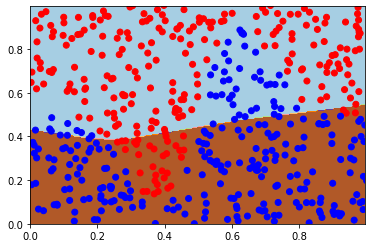

Epoch: [21/200][0/4]	LR: 0.01	Loss 0.3950 (0.3950)	Train Acc 83.203 (83.203)
 * Train Acc 82.750
Test: [0/2]	Loss 0.3424 (0.3424)	Prec@1 86.328 (86.328)
 * Test Acc 86.333
-----------------------------------------------
Epoch: [22/200][0/4]	LR: 0.01	Loss 0.3874 (0.3874)	Train Acc 85.938 (85.938)
 * Train Acc 83.625
Test: [0/2]	Loss 0.3519 (0.3519)	Prec@1 87.109 (87.109)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [23/200][0/4]	LR: 0.01	Loss 0.4373 (0.4373)	Train Acc 80.859 (80.859)
 * Train Acc 82.250
Test: [0/2]	Loss 0.3739 (0.3739)	Prec@1 86.328 (86.328)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [24/200][0/4]	LR: 0.01	Loss 0.3884 (0.3884)	Train Acc 83.594 (83.594)
 * Train Acc 82.875
Test: [0/2]	Loss 0.3718 (0.3718)	Prec@1 86.328 (86.328)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [25/200][0/4]	LR: 0.01	Loss 0.4272 (0.4272)	Train Acc 83.984 (83.984)
 * Train Acc 83.875
Test: [0/2]	Loss 0.3533

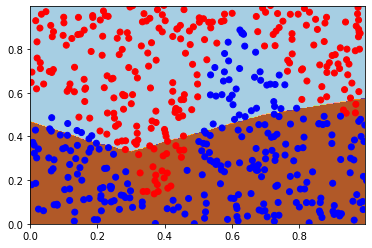

Epoch: [31/200][0/4]	LR: 0.01	Loss 0.4032 (0.4032)	Train Acc 83.984 (83.984)
 * Train Acc 84.000
Test: [0/2]	Loss 0.3291 (0.3291)	Prec@1 87.891 (87.891)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [32/200][0/4]	LR: 0.01	Loss 0.4202 (0.4202)	Train Acc 82.422 (82.422)
 * Train Acc 84.250
Test: [0/2]	Loss 0.3620 (0.3620)	Prec@1 82.422 (82.422)
 * Test Acc 84.333
-----------------------------------------------
Epoch: [33/200][0/4]	LR: 0.01	Loss 0.4116 (0.4116)	Train Acc 82.422 (82.422)
 * Train Acc 82.125
Test: [0/2]	Loss 0.3392 (0.3392)	Prec@1 84.766 (84.766)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [34/200][0/4]	LR: 0.01	Loss 0.4168 (0.4168)	Train Acc 82.422 (82.422)
 * Train Acc 84.500
Test: [0/2]	Loss 0.3234 (0.3234)	Prec@1 86.719 (86.719)
 * Test Acc 86.333
-----------------------------------------------
Epoch: [35/200][0/4]	LR: 0.01	Loss 0.3590 (0.3590)	Train Acc 86.719 (86.719)
 * Train Acc 84.750
Test: [0/2]	Loss 0.3336

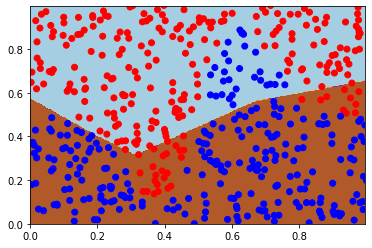

Epoch: [41/200][0/4]	LR: 0.01	Loss 0.3988 (0.3988)	Train Acc 83.203 (83.203)
 * Train Acc 84.625
Test: [0/2]	Loss 0.3034 (0.3034)	Prec@1 85.938 (85.938)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [42/200][0/4]	LR: 0.01	Loss 0.3236 (0.3236)	Train Acc 88.281 (88.281)
 * Train Acc 85.750
Test: [0/2]	Loss 0.3217 (0.3217)	Prec@1 84.375 (84.375)
 * Test Acc 85.667
-----------------------------------------------
Epoch: [43/200][0/4]	LR: 0.01	Loss 0.3836 (0.3836)	Train Acc 86.328 (86.328)
 * Train Acc 85.625
Test: [0/2]	Loss 0.3284 (0.3284)	Prec@1 84.375 (84.375)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [44/200][0/4]	LR: 0.01	Loss 0.3232 (0.3232)	Train Acc 85.938 (85.938)
 * Train Acc 85.000
Test: [0/2]	Loss 0.3267 (0.3267)	Prec@1 85.938 (85.938)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [45/200][0/4]	LR: 0.01	Loss 0.3142 (0.3142)	Train Acc 88.281 (88.281)
 * Train Acc 85.750
Test: [0/2]	Loss 0.3149

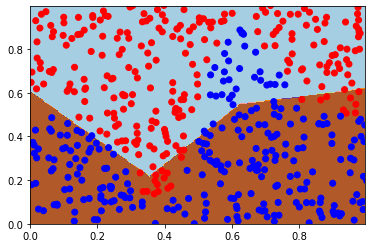

Epoch: [51/200][0/4]	LR: 0.01	Loss 0.3558 (0.3558)	Train Acc 85.938 (85.938)
 * Train Acc 86.375
Test: [0/2]	Loss 0.2820 (0.2820)	Prec@1 88.281 (88.281)
 * Test Acc 88.000
-----------------------------------------------
Epoch: [52/200][0/4]	LR: 0.01	Loss 0.3316 (0.3316)	Train Acc 87.891 (87.891)
 * Train Acc 86.000
Test: [0/2]	Loss 0.2940 (0.2940)	Prec@1 84.766 (84.766)
 * Test Acc 85.333
-----------------------------------------------
Epoch: [53/200][0/4]	LR: 0.01	Loss 0.3018 (0.3018)	Train Acc 87.891 (87.891)
 * Train Acc 87.250
Test: [0/2]	Loss 0.2890 (0.2890)	Prec@1 87.891 (87.891)
 * Test Acc 87.667
-----------------------------------------------
Epoch: [54/200][0/4]	LR: 0.01	Loss 0.3188 (0.3188)	Train Acc 87.109 (87.109)
 * Train Acc 87.375
Test: [0/2]	Loss 0.2824 (0.2824)	Prec@1 87.109 (87.109)
 * Test Acc 84.000
-----------------------------------------------
Epoch: [55/200][0/4]	LR: 0.01	Loss 0.2939 (0.2939)	Train Acc 87.500 (87.500)
 * Train Acc 85.500
Test: [0/2]	Loss 0.2927

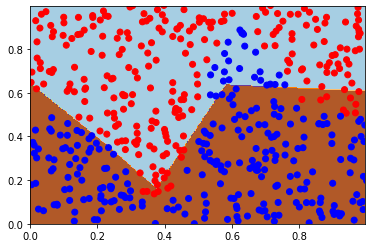

Epoch: [61/200][0/4]	LR: 0.01	Loss 0.2987 (0.2987)	Train Acc 89.453 (89.453)
 * Train Acc 87.875
Test: [0/2]	Loss 0.2847 (0.2847)	Prec@1 90.625 (90.625)
 * Test Acc 91.333
-----------------------------------------------
Epoch: [62/200][0/4]	LR: 0.01	Loss 0.2657 (0.2657)	Train Acc 91.016 (91.016)
 * Train Acc 88.625
Test: [0/2]	Loss 0.2421 (0.2421)	Prec@1 88.281 (88.281)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [63/200][0/4]	LR: 0.01	Loss 0.2714 (0.2714)	Train Acc 87.500 (87.500)
 * Train Acc 89.500
Test: [0/2]	Loss 0.2764 (0.2764)	Prec@1 86.328 (86.328)
 * Test Acc 87.333
-----------------------------------------------
Epoch: [64/200][0/4]	LR: 0.01	Loss 0.2966 (0.2966)	Train Acc 89.453 (89.453)
 * Train Acc 89.000
Test: [0/2]	Loss 0.2550 (0.2550)	Prec@1 90.625 (90.625)
 * Test Acc 90.667
-----------------------------------------------
Epoch: [65/200][0/4]	LR: 0.01	Loss 0.2593 (0.2593)	Train Acc 90.625 (90.625)
 * Train Acc 88.750
Test: [0/2]	Loss 0.2340

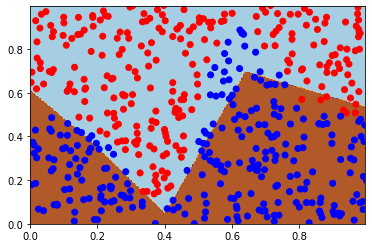

Epoch: [71/200][0/4]	LR: 0.01	Loss 0.2311 (0.2311)	Train Acc 91.406 (91.406)
 * Train Acc 88.625
Test: [0/2]	Loss 0.2598 (0.2598)	Prec@1 87.500 (87.500)
 * Test Acc 88.000
-----------------------------------------------
Epoch: [72/200][0/4]	LR: 0.01	Loss 0.2017 (0.2017)	Train Acc 91.406 (91.406)
 * Train Acc 90.250
Test: [0/2]	Loss 0.2499 (0.2499)	Prec@1 91.016 (91.016)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [73/200][0/4]	LR: 0.01	Loss 0.3405 (0.3405)	Train Acc 87.500 (87.500)
 * Train Acc 90.125
Test: [0/2]	Loss 0.2289 (0.2289)	Prec@1 91.797 (91.797)
 * Test Acc 91.000
-----------------------------------------------
Epoch: [74/200][0/4]	LR: 0.01	Loss 0.2434 (0.2434)	Train Acc 87.891 (87.891)
 * Train Acc 90.375
Test: [0/2]	Loss 0.2075 (0.2075)	Prec@1 92.578 (92.578)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [75/200][0/4]	LR: 0.01	Loss 0.2588 (0.2588)	Train Acc 90.234 (90.234)
 * Train Acc 91.375
Test: [0/2]	Loss 0.1999

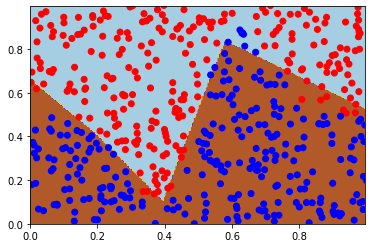

Epoch: [81/200][0/4]	LR: 0.01	Loss 0.2309 (0.2309)	Train Acc 92.578 (92.578)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1937 (0.1937)	Prec@1 92.188 (92.188)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [82/200][0/4]	LR: 0.01	Loss 0.2288 (0.2288)	Train Acc 91.406 (91.406)
 * Train Acc 92.625
Test: [0/2]	Loss 0.2010 (0.2010)	Prec@1 93.359 (93.359)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [83/200][0/4]	LR: 0.01	Loss 0.2317 (0.2317)	Train Acc 93.750 (93.750)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1862 (0.1862)	Prec@1 92.578 (92.578)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [84/200][0/4]	LR: 0.01	Loss 0.2331 (0.2331)	Train Acc 92.969 (92.969)
 * Train Acc 92.875
Test: [0/2]	Loss 0.1901 (0.1901)	Prec@1 93.750 (93.750)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [85/200][0/4]	LR: 0.01	Loss 0.2234 (0.2234)	Train Acc 94.141 (94.141)
 * Train Acc 92.500
Test: [0/2]	Loss 0.1790

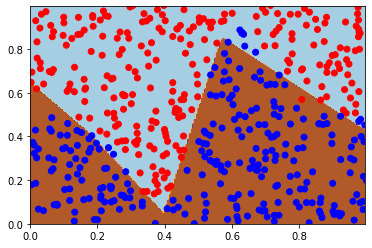

Epoch: [91/200][0/4]	LR: 0.01	Loss 0.2449 (0.2449)	Train Acc 93.750 (93.750)
 * Train Acc 94.625
Test: [0/2]	Loss 0.1771 (0.1771)	Prec@1 92.969 (92.969)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [92/200][0/4]	LR: 0.01	Loss 0.2798 (0.2798)	Train Acc 93.359 (93.359)
 * Train Acc 93.625
Test: [0/2]	Loss 0.2085 (0.2085)	Prec@1 92.188 (92.188)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [93/200][0/4]	LR: 0.01	Loss 0.1995 (0.1995)	Train Acc 93.359 (93.359)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1823 (0.1823)	Prec@1 92.188 (92.188)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [94/200][0/4]	LR: 0.01	Loss 0.2719 (0.2719)	Train Acc 87.500 (87.500)
 * Train Acc 91.500
Test: [0/2]	Loss 0.2128 (0.2128)	Prec@1 91.016 (91.016)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [95/200][0/4]	LR: 0.01	Loss 0.2311 (0.2311)	Train Acc 91.797 (91.797)
 * Train Acc 93.125
Test: [0/2]	Loss 0.1841

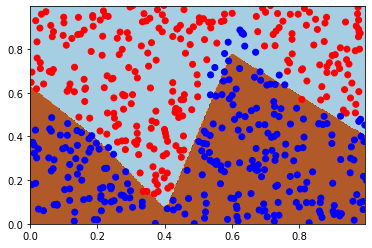

Epoch: [101/200][0/4]	LR: 0.01	Loss 0.2095 (0.2095)	Train Acc 91.797 (91.797)
 * Train Acc 91.750
Test: [0/2]	Loss 0.1544 (0.1544)	Prec@1 92.969 (92.969)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [102/200][0/4]	LR: 0.01	Loss 0.2062 (0.2062)	Train Acc 94.531 (94.531)
 * Train Acc 92.750
Test: [0/2]	Loss 0.1914 (0.1914)	Prec@1 92.188 (92.188)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [103/200][0/4]	LR: 0.01	Loss 0.2126 (0.2126)	Train Acc 91.797 (91.797)
 * Train Acc 92.375
Test: [0/2]	Loss 0.1773 (0.1773)	Prec@1 92.578 (92.578)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [104/200][0/4]	LR: 0.01	Loss 0.1794 (0.1794)	Train Acc 95.703 (95.703)
 * Train Acc 93.625
Test: [0/2]	Loss 0.1691 (0.1691)	Prec@1 94.141 (94.141)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [105/200][0/4]	LR: 0.01	Loss 0.2334 (0.2334)	Train Acc 93.750 (93.750)
 * Train Acc 93.875
Test: [0/2]	Loss 0

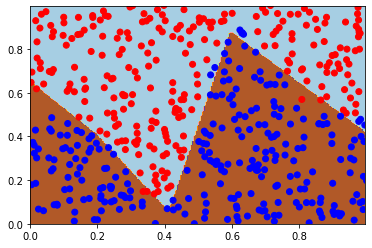

Epoch: [111/200][0/4]	LR: 0.01	Loss 0.1669 (0.1669)	Train Acc 94.531 (94.531)
 * Train Acc 92.250
Test: [0/2]	Loss 0.2485 (0.2485)	Prec@1 87.500 (87.500)
 * Test Acc 87.333
-----------------------------------------------
Epoch: [112/200][0/4]	LR: 0.01	Loss 0.2313 (0.2313)	Train Acc 89.062 (89.062)
 * Train Acc 88.875
Test: [0/2]	Loss 0.1682 (0.1682)	Prec@1 92.969 (92.969)
 * Test Acc 93.333
-----------------------------------------------
Epoch: [113/200][0/4]	LR: 0.01	Loss 0.2760 (0.2760)	Train Acc 90.625 (90.625)
 * Train Acc 92.375
Test: [0/2]	Loss 0.1560 (0.1560)	Prec@1 95.312 (95.312)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [114/200][0/4]	LR: 0.01	Loss 0.2031 (0.2031)	Train Acc 95.312 (95.312)
 * Train Acc 92.875
Test: [0/2]	Loss 0.1655 (0.1655)	Prec@1 94.922 (94.922)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [115/200][0/4]	LR: 0.01	Loss 0.2300 (0.2300)	Train Acc 94.141 (94.141)
 * Train Acc 93.000
Test: [0/2]	Loss 0

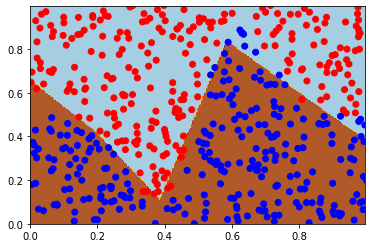

Epoch: [121/200][0/4]	LR: 0.01	Loss 0.2542 (0.2542)	Train Acc 90.234 (90.234)
 * Train Acc 92.875
Test: [0/2]	Loss 0.1699 (0.1699)	Prec@1 93.750 (93.750)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [122/200][0/4]	LR: 0.01	Loss 0.1860 (0.1860)	Train Acc 95.312 (95.312)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1388 (0.1388)	Prec@1 94.531 (94.531)
 * Test Acc 93.667
-----------------------------------------------
Epoch: [123/200][0/4]	LR: 0.01	Loss 0.2100 (0.2100)	Train Acc 93.359 (93.359)
 * Train Acc 93.625
Test: [0/2]	Loss 0.1729 (0.1729)	Prec@1 94.531 (94.531)
 * Test Acc 94.667
-----------------------------------------------
Epoch: [124/200][0/4]	LR: 0.01	Loss 0.2182 (0.2182)	Train Acc 92.969 (92.969)
 * Train Acc 93.625
Test: [0/2]	Loss 0.1569 (0.1569)	Prec@1 94.531 (94.531)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [125/200][0/4]	LR: 0.01	Loss 0.1824 (0.1824)	Train Acc 94.141 (94.141)
 * Train Acc 93.500
Test: [0/2]	Loss 0

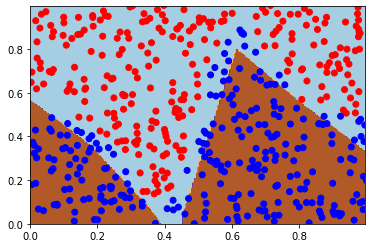

Epoch: [131/200][0/4]	LR: 0.01	Loss 0.2349 (0.2349)	Train Acc 91.797 (91.797)
 * Train Acc 90.875
Test: [0/2]	Loss 0.2854 (0.2854)	Prec@1 83.984 (83.984)
 * Test Acc 83.667
-----------------------------------------------
Epoch: [132/200][0/4]	LR: 0.01	Loss 0.2978 (0.2978)	Train Acc 85.156 (85.156)
 * Train Acc 88.000
Test: [0/2]	Loss 0.1985 (0.1985)	Prec@1 91.797 (91.797)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [133/200][0/4]	LR: 0.01	Loss 0.2997 (0.2997)	Train Acc 89.062 (89.062)
 * Train Acc 90.125
Test: [0/2]	Loss 0.2181 (0.2181)	Prec@1 90.234 (90.234)
 * Test Acc 88.000
-----------------------------------------------
Epoch: [134/200][0/4]	LR: 0.01	Loss 0.2108 (0.2108)	Train Acc 92.188 (92.188)
 * Train Acc 91.000
Test: [0/2]	Loss 0.2243 (0.2243)	Prec@1 91.797 (91.797)
 * Test Acc 92.000
-----------------------------------------------
Epoch: [135/200][0/4]	LR: 0.01	Loss 0.2765 (0.2765)	Train Acc 87.891 (87.891)
 * Train Acc 88.000
Test: [0/2]	Loss 0

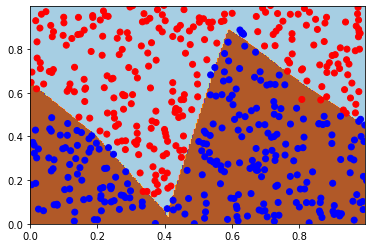

Epoch: [141/200][0/4]	LR: 0.01	Loss 0.2254 (0.2254)	Train Acc 92.578 (92.578)
 * Train Acc 94.125
Test: [0/2]	Loss 0.1582 (0.1582)	Prec@1 94.531 (94.531)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [142/200][0/4]	LR: 0.01	Loss 0.1883 (0.1883)	Train Acc 92.578 (92.578)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1632 (0.1632)	Prec@1 95.703 (95.703)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [143/200][0/4]	LR: 0.01	Loss 0.2159 (0.2159)	Train Acc 93.359 (93.359)
 * Train Acc 94.125
Test: [0/2]	Loss 0.1945 (0.1945)	Prec@1 93.359 (93.359)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [144/200][0/4]	LR: 0.01	Loss 0.2090 (0.2090)	Train Acc 92.969 (92.969)
 * Train Acc 92.500
Test: [0/2]	Loss 0.1378 (0.1378)	Prec@1 93.750 (93.750)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [145/200][0/4]	LR: 0.01	Loss 0.1924 (0.1924)	Train Acc 92.578 (92.578)
 * Train Acc 93.625
Test: [0/2]	Loss 0

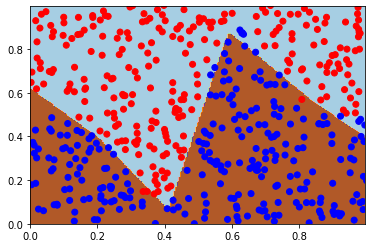

Epoch: [151/200][0/4]	LR: 0.01	Loss 0.2044 (0.2044)	Train Acc 94.922 (94.922)
 * Train Acc 93.750
Test: [0/2]	Loss 0.1388 (0.1388)	Prec@1 96.094 (96.094)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [152/200][0/4]	LR: 0.01	Loss 0.2171 (0.2171)	Train Acc 93.750 (93.750)
 * Train Acc 95.000
Test: [0/2]	Loss 0.1500 (0.1500)	Prec@1 95.312 (95.312)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [153/200][0/4]	LR: 0.01	Loss 0.1872 (0.1872)	Train Acc 94.141 (94.141)
 * Train Acc 93.750
Test: [0/2]	Loss 0.2008 (0.2008)	Prec@1 90.234 (90.234)
 * Test Acc 90.333
-----------------------------------------------
Epoch: [154/200][0/4]	LR: 0.01	Loss 0.1871 (0.1871)	Train Acc 93.750 (93.750)
 * Train Acc 90.875
Test: [0/2]	Loss 0.1503 (0.1503)	Prec@1 94.531 (94.531)
 * Test Acc 93.667
-----------------------------------------------
Epoch: [155/200][0/4]	LR: 0.01	Loss 0.2415 (0.2415)	Train Acc 87.500 (87.500)
 * Train Acc 89.375
Test: [0/2]	Loss 0

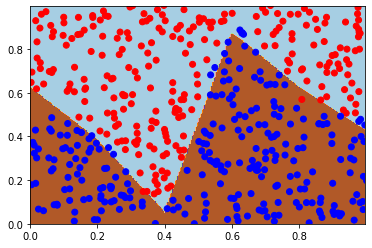

Epoch: [161/200][0/4]	LR: 0.01	Loss 0.2136 (0.2136)	Train Acc 94.141 (94.141)
 * Train Acc 92.375
Test: [0/2]	Loss 0.1491 (0.1491)	Prec@1 94.922 (94.922)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [162/200][0/4]	LR: 0.01	Loss 0.2122 (0.2122)	Train Acc 94.141 (94.141)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1427 (0.1427)	Prec@1 96.094 (96.094)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [163/200][0/4]	LR: 0.01	Loss 0.1511 (0.1511)	Train Acc 94.922 (94.922)
 * Train Acc 93.125
Test: [0/2]	Loss 0.1483 (0.1483)	Prec@1 94.531 (94.531)
 * Test Acc 94.667
-----------------------------------------------
Epoch: [164/200][0/4]	LR: 0.01	Loss 0.1609 (0.1609)	Train Acc 95.703 (95.703)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1600 (0.1600)	Prec@1 94.141 (94.141)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [165/200][0/4]	LR: 0.01	Loss 0.2075 (0.2075)	Train Acc 92.578 (92.578)
 * Train Acc 93.250
Test: [0/2]	Loss 0

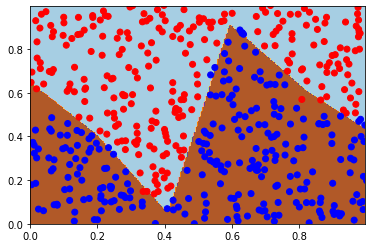

Epoch: [171/200][0/4]	LR: 0.01	Loss 0.1560 (0.1560)	Train Acc 95.312 (95.312)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1654 (0.1654)	Prec@1 94.531 (94.531)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [172/200][0/4]	LR: 0.01	Loss 0.2431 (0.2431)	Train Acc 91.797 (91.797)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1454 (0.1454)	Prec@1 94.922 (94.922)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [173/200][0/4]	LR: 0.01	Loss 0.1563 (0.1563)	Train Acc 95.312 (95.312)
 * Train Acc 94.375
Test: [0/2]	Loss 0.1611 (0.1611)	Prec@1 93.359 (93.359)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [174/200][0/4]	LR: 0.01	Loss 0.2181 (0.2181)	Train Acc 93.750 (93.750)
 * Train Acc 94.375
Test: [0/2]	Loss 0.1583 (0.1583)	Prec@1 94.922 (94.922)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [175/200][0/4]	LR: 0.01	Loss 0.2311 (0.2311)	Train Acc 93.750 (93.750)
 * Train Acc 94.750
Test: [0/2]	Loss 0

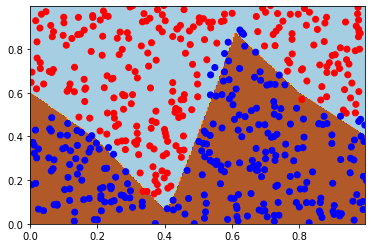

Epoch: [181/200][0/4]	LR: 0.01	Loss 0.1962 (0.1962)	Train Acc 94.531 (94.531)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1513 (0.1513)	Prec@1 92.969 (92.969)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [182/200][0/4]	LR: 0.01	Loss 0.2552 (0.2552)	Train Acc 90.625 (90.625)
 * Train Acc 93.125
Test: [0/2]	Loss 0.1333 (0.1333)	Prec@1 94.531 (94.531)
 * Test Acc 94.667
-----------------------------------------------
Epoch: [183/200][0/4]	LR: 0.01	Loss 0.1893 (0.1893)	Train Acc 93.750 (93.750)
 * Train Acc 94.125
Test: [0/2]	Loss 0.1553 (0.1553)	Prec@1 94.922 (94.922)
 * Test Acc 94.333
-----------------------------------------------
Epoch: [184/200][0/4]	LR: 0.01	Loss 0.1915 (0.1915)	Train Acc 94.531 (94.531)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1211 (0.1211)	Prec@1 94.922 (94.922)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [185/200][0/4]	LR: 0.01	Loss 0.2085 (0.2085)	Train Acc 92.969 (92.969)
 * Train Acc 93.125
Test: [0/2]	Loss 0

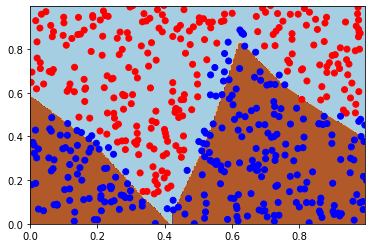

Epoch: [191/200][0/4]	LR: 0.01	Loss 0.2240 (0.2240)	Train Acc 91.797 (91.797)
 * Train Acc 91.875
Test: [0/2]	Loss 0.2144 (0.2144)	Prec@1 91.016 (91.016)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [192/200][0/4]	LR: 0.01	Loss 0.2273 (0.2273)	Train Acc 92.188 (92.188)
 * Train Acc 92.625
Test: [0/2]	Loss 0.1659 (0.1659)	Prec@1 92.578 (92.578)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [193/200][0/4]	LR: 0.01	Loss 0.2400 (0.2400)	Train Acc 90.234 (90.234)
 * Train Acc 91.375
Test: [0/2]	Loss 0.1978 (0.1978)	Prec@1 92.188 (92.188)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [194/200][0/4]	LR: 0.01	Loss 0.2555 (0.2555)	Train Acc 89.453 (89.453)
 * Train Acc 91.750
Test: [0/2]	Loss 0.1835 (0.1835)	Prec@1 92.969 (92.969)
 * Test Acc 93.333
-----------------------------------------------
Epoch: [195/200][0/4]	LR: 0.01	Loss 0.1895 (0.1895)	Train Acc 92.188 (92.188)
 * Train Acc 88.625
Test: [0/2]	Loss 0

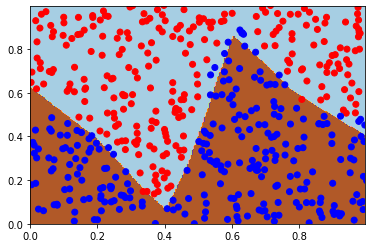

In [228]:
epoch_list = []
loss_list = []
acc_list = []
lr_list = []
val_acc_list = []
test_acc_list = []
num_net_param = []

best_prec1 = 0
for epoch in range(num_epochs):
    if epoch in lr_step:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    # prec1 = 0
    prec1 = validate(val_loader, model, criterion)
    total_params = sum(p.numel() for p in model.parameters())
    num_net_param.append(total_params)
    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best,filename="checkpoint.pth.tar")
    print("-----------------------------------------------")
    
    if epoch%print_freq==0:
        plot_decision_boundary(model)

plot_decision_boundary(model)

# Question 2 - A two-dimensional classification task

## (a) Plot epochs vs training loss and training accuracy vs validation accuracy

In [65]:
a=len(epoch_list)
b=len(lr_list)
c=len(loss_list)
d=len(acc_list)
e=len(val_acc_list)
print(a,b,c,d,e)

200 200 200 200 200


In [68]:
import pandas as pd

data_dict = {'epoch': epoch_list,
             'learn_rate': lr_list,
             'training_loss': loss_list,
             'training_accuracy': np.array(acc_list),
             'validation_accuracy': np.array(val_acc_list)}

df = pd.DataFrame(data_dict)
print(df.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0        0.01       0.187370             94.000            95.333336
1      1        0.01       0.185312             94.000            94.000000
2      2        0.01       0.190191             93.250            95.333336
3      3        0.01       0.187409             95.125            95.333336
4      4        0.01       0.185347             94.125            95.333336


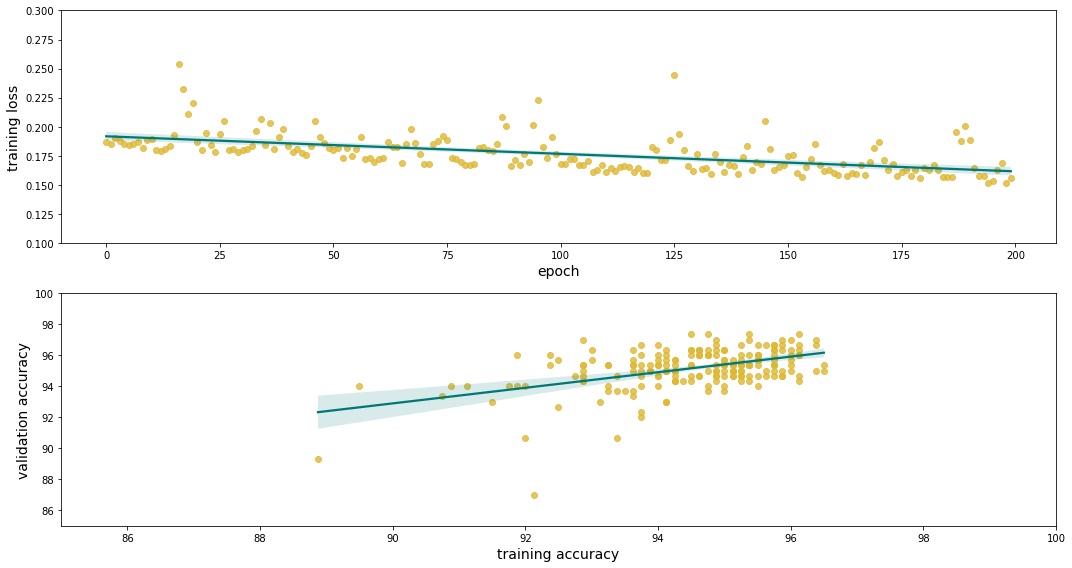

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
f, axes = plt.subplots(2,1,figsize=(15,8))

ax= sns.regplot(data=df, x="epoch",y="training_loss",scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"}, ax=axes[0])
ax.set_xlabel("epoch", fontsize=14)
ax.set_ylabel("training loss", fontsize=14)
ax.set_ylim(0.1, 0.3)

ax1 = sns.regplot(data=df, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"}, ax=axes[1])
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
ax1.set_xlim(85,100)
ax1.set_ylim(85,100)

f.tight_layout()

### change in training loss with epochs
There is a gradual negative trend for training loss with epochs. It makes sense that the training loss would decrease as the model learns to make better predictions and therefore improves with each iteration.

### training accuracy vs validation accuracy
There is a positive trend between validation accuracy and training accuracy. As the model improves its training accuracy, it is tweaking weights and biases to more accurately capture the training dataset. Therefore, it makes sense that as accuracy improves on the training data, it would also improve on a similar validation set. 

That being said, as the training data approaches 100% accuracy we would want to avoid overfitting. If the model begins overfitting the training data, we may see accuracy on the validation data begin to decrease slightly.

## (b) Effect of learning rate: lr = 1, 0.1, 0.01, 0.001, 0.0001

### learn rate = 1.0

In [118]:
a=len(epoch_list_1)
b=len(lr_list_1)
c=len(loss_list_1)
d=len(acc_list_1)
e=len(val_acc_list_1)
print(a,b,c,d,e)

200 200 200 200 200


In [105]:
data_dict_1 = {'epoch': epoch_list_1,
             'learn_rate': lr_list_1,
             'training_loss': loss_list_1,
             'training_accuracy': np.array(acc_list_1),
             'validation_accuracy': np.array(val_acc_list_1)}

df_1 = pd.DataFrame(data_dict_1)
print(df_1.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0         1.0      36.696698             57.500            51.666668
1      1         1.0       1.711338             42.250            50.000000
2      2         1.0       0.702489             49.000            50.000000
3      3         1.0       1.001838             47.750            70.666664
4      4         1.0       1.080256             57.625            52.000000


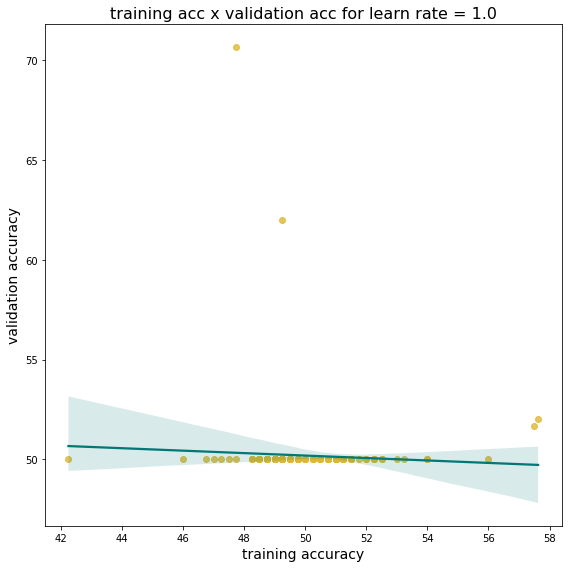

In [185]:
f, axes = plt.subplots(1,1,figsize=(8,8))
ax1 = sns.regplot(data=df_1, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
#ax1.set_xlim(40,60)
#ax1.set_ylim(45,75)
ax1.set_title('training acc x validation acc for learn rate = 1.0', fontsize=16)

f.tight_layout()

### learn rate = 0.1

In [134]:
data_dict_pt1 = {'epoch': epoch_list_pt1,
             'learn_rate': lr_list_pt1,
             'training_loss': loss_list_pt1,
             'training_accuracy': np.array(acc_list_pt1),
             'validation_accuracy': np.array(val_acc_list_pt1)}

df_pt1 = pd.DataFrame(data_dict_pt1)
print(df_pt1.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0         0.1       0.698607             50.250            61.000000
1      1         0.1       0.591260             68.250            79.000000
2      2         0.1       0.502196             75.375            85.000000
3      3         0.1       0.524424             76.250            78.666664
4      4         0.1       0.518434             77.625            76.666664


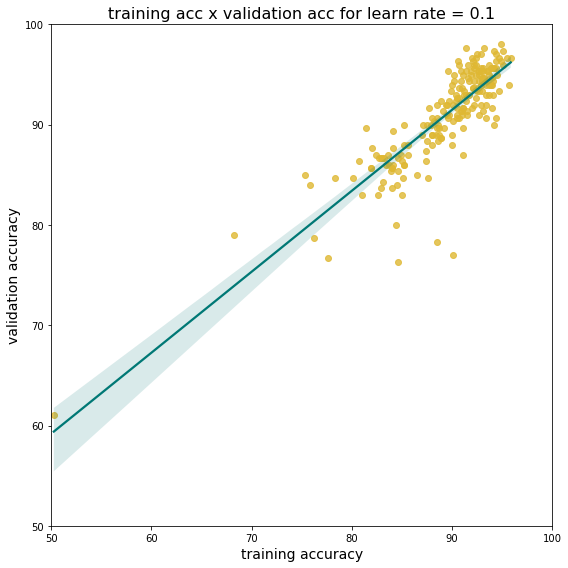

In [184]:
f, axes = plt.subplots(1,1,figsize=(8,8))
ax1 = sns.regplot(data=df_pt1, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
ax1.set_xlim(50,100)
ax1.set_ylim(50,100)
ax1.set_title('training acc x validation acc for learn rate = 0.1', fontsize=16)

f.tight_layout()

### learn rate = 0.01

In [148]:
data_dict_pt01 = {'epoch': epoch_list_pt01,
             'learn_rate': lr_list_pt01,
             'training_loss': loss_list_pt01,
             'training_accuracy': np.array(acc_list_pt01),
             'validation_accuracy': np.array(val_acc_list_pt01)}

df_pt01 = pd.DataFrame(data_dict_pt01)
print(df_pt01.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0        0.01       0.693393             52.750            83.000000
1      1        0.01       0.677805             78.250            75.333336
2      2        0.01       0.654768             75.875            78.666664
3      3        0.01       0.618898             76.500            78.333336
4      4        0.01       0.569845             76.500            80.333336


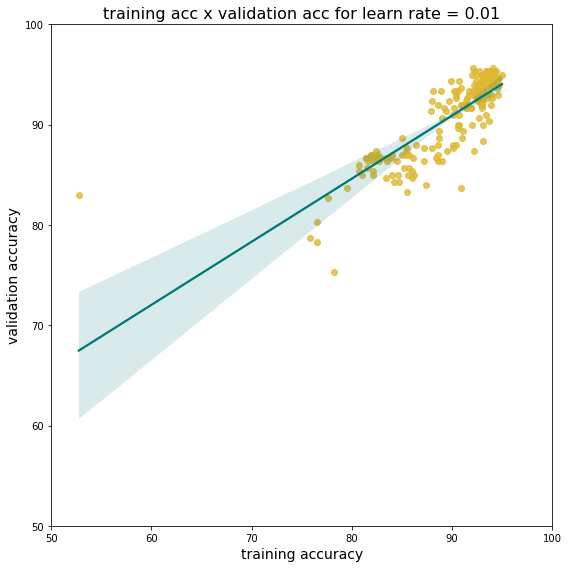

In [152]:
f, axes = plt.subplots(1,1,figsize=(8,8))
ax1 = sns.regplot(data=df_pt01, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
ax1.set_xlim(50,100)
ax1.set_ylim(50,100)
ax1.set_title('training acc x validation acc for learn rate = 0.01', fontsize=16)

f.tight_layout()

### learn rate = 0.001

In [164]:
data_dict_pt001 = {'epoch': epoch_list_pt001,
             'learn_rate': lr_list_pt001,
             'training_loss': loss_list_pt001,
             'training_accuracy': np.array(acc_list_pt001),
             'validation_accuracy': np.array(val_acc_list_pt001)}

df_pt001 = pd.DataFrame(data_dict_pt001)
print(df_pt001.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0       0.001       0.699408               51.0                 50.0
1      1       0.001       0.696356               51.0                 50.0
2      2       0.001       0.693891               51.0                 50.0
3      3       0.001       0.691866               51.0                 50.0
4      4       0.001       0.690207               51.0                 50.0


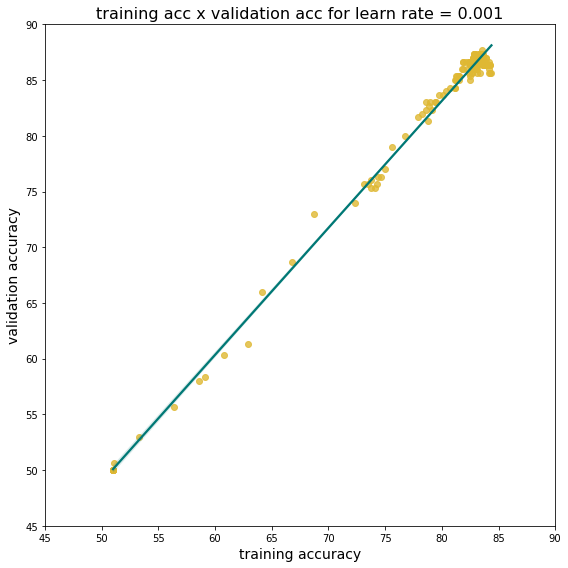

In [169]:
f, axes = plt.subplots(1,1,figsize=(8,8))
ax1 = sns.regplot(data=df_pt001, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
ax1.set_xlim(45,90)
ax1.set_ylim(45,90)
ax1.set_title('training acc x validation acc for learn rate = 0.001', fontsize=16)

f.tight_layout()

### learn rate = 0.0001

In [182]:
data_dict_pt0001 = {'epoch': epoch_list_pt0001,
             'learn_rate': lr_list_pt0001,
             'training_loss': loss_list_pt0001,
             'training_accuracy': np.array(acc_list_pt0001),
             'validation_accuracy': np.array(val_acc_list_pt0001)}

df_pt0001 = pd.DataFrame(data_dict_pt0001)
print(df_pt0001.head())

   epoch  learn_rate  training_loss  training_accuracy  validation_accuracy
0      0      0.0001       0.700271               51.0                 50.0
1      1      0.0001       0.699931               51.0                 50.0
2      2      0.0001       0.699612               51.0                 50.0
3      3      0.0001       0.699310               51.0                 50.0
4      4      0.0001       0.699028               51.0                 50.0


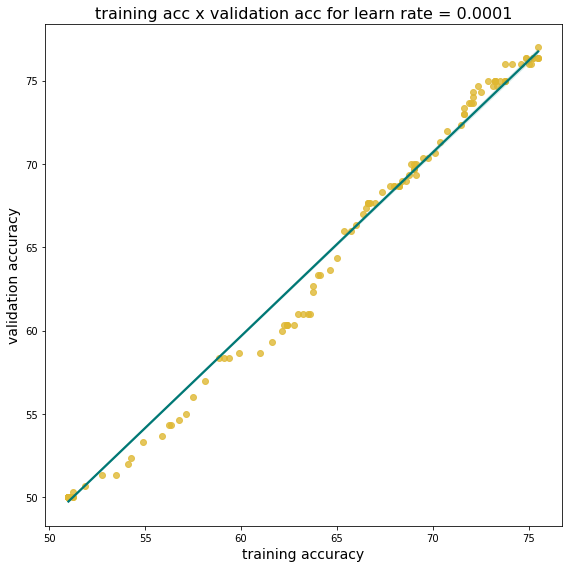

In [183]:
f, axes = plt.subplots(1,1,figsize=(8,8))
ax1 = sns.regplot(data=df_pt0001, x="training_accuracy", y="validation_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("validation accuracy", fontsize=14)
#ax1.set_xlim(40,60)
#ax1.set_ylim(45,75)
ax1.set_title('training acc x validation acc for learn rate = 0.0001', fontsize=16)

f.tight_layout()

### Choosing best learn rate

#### learn rate = 1.0 
- The learn rate is too high and the model seems to be failing to converge at the loss minimum. This could be due to the model overshooting the minimum due to large step size. The trend is a flat line
<br>
<br>

#### learn rate = 0.1
- This learn rate is a great choice. Almost all poitn for training accuracy x validation accuracy are clustered bewteen 80-100%. That being said, it does appear that there are some cases where validation accuracy is lower than training accuracy when compared to the tightness of clusters seen in the learn rate 0.01 model, so this is not the optimal choice. The tred is positive
<br>
<br>

#### learn rate = 0.01 
- This is the best learn rate option. Both training accuracy and validation accuracy are clustered tightly between 80-100% and the trend is positive.
<br>
<br> 

#### learn rates = 0.001 and 0.0001 
- Both of these learn rate options seem to be underfitting the model. The maximum accuracy for both train/validation is well below that of the 0.01 and 0.1 models. Additionally, the points are evenly distributed along a positive trend line from 50-90% for 0.001 and 50-75% for 0.0001. These low accuracies imply that the models are struggling to identify patterns in the data and therefore have low accuracy.

## (c) 1 hidden layer with 100 neurons

### Single layer with 100 neurons

In [207]:
data_dict_100n = {'epoch': epoch_list_100,
             'learn_rate': lr_list_100,
             'training_loss': loss_list_100,
             'training_accuracy': np.array(acc_list_100),
             'test_accuracy': np.array(test_acc_list_100)
            }

df_100n = pd.DataFrame(data_dict_100n)
print(df_100n.head())

   epoch  learn_rate  training_loss  training_accuracy  test_accuracy
0      0        0.01       0.227759             93.000      93.666664
1      1        0.01       0.223513             93.625      93.333336
2      2        0.01       0.223046             93.500      92.666664
3      3        0.01       0.224428             93.250      93.000000
4      4        0.01       0.223450             93.250      93.333336


In [245]:
final_training_accuracy = np.array(acc_list_100[-1])
final_test_accuracy = np.array(test_acc_list_100[-1])
num_network_param = num_net_param_100[0]

print("number of network parameters: ", num_network_param)
print("final training accuracy: ",final_training_accuracy)
print("final test accuracy: ", final_test_accuracy)

number of network parameters:  502
final training accuracy:  93.625
final test accuracy:  95.333336


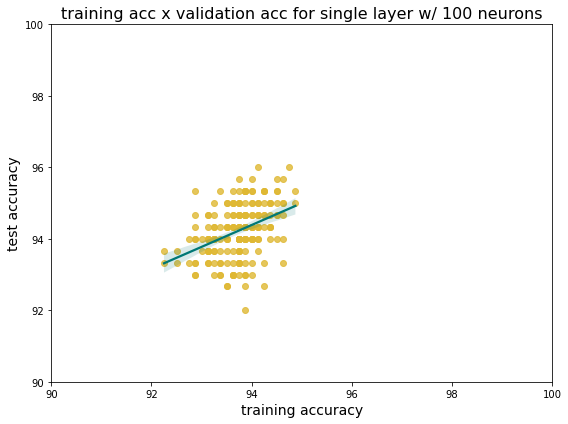

In [234]:
f, axes = plt.subplots(1,1,figsize=(8,6))
ax1 = sns.regplot(data=df_100n, x="training_accuracy", y="test_accuracy", scatter_kws={"color": "#dfb833"}, line_kws={"color": "#007875"})
ax1.set_xlabel("training accuracy", fontsize=14)
ax1.set_ylabel("test accuracy", fontsize=14)
ax1.set_xlim(90,100)
ax1.set_ylim(90,100)
ax1.set_title('training acc x validation acc for single layer w/ 100 neurons', fontsize=16)

f.tight_layout()

### 3 hidden layers: 20, 10, 10

In [230]:
test_acc_list
num_net_param[0]
acc_list

402

In [233]:
data_dict = {'epoch': epoch_list,
             'learn_rate': lr_list,
             'training_loss': loss_list,
             'training_accuracy': np.array(acc_list),
             'test_accuracy': np.array(test_acc_list)
            }

df = pd.DataFrame(data_dict)
print(df.head())

   epoch  learn_rate  training_loss  training_accuracy  test_accuracy
0      0        0.01       0.693393             52.750      83.000000
1      1        0.01       0.677805             78.250      75.333336
2      2        0.01       0.654768             75.875      78.666664
3      3        0.01       0.618898             76.500      78.333336
4      4        0.01       0.569845             76.500      80.333336


In [247]:
final_training_accuracy = np.array(acc_list[-1])
final_test_accuracy = np.array(test_acc_list[-1])
num_network_param = num_net_param[0]

print("number of network parameters: ", num_network_param)
print("final training accuracy: ",final_training_accuracy)
print("final test accuracy: ", final_test_accuracy)

number of network parameters:  402
final training accuracy:  94.5
final test accuracy:  93.666664


### single layer with 100 neurons

In [249]:
final_training_accuracy = np.array(acc_list_100[-1])
final_test_accuracy = np.array(test_acc_list_100[-1])
num_network_param = num_net_param_100[0]

print("number of network parameters: ", num_network_param)
print("final training accuracy: ",final_training_accuracy)
print("final test accuracy: ", final_test_accuracy)

number of network parameters:  502
final training accuracy:  93.625
final test accuracy:  95.333336


### three hidden layers with 20,10,10 neurons

In [248]:
final_training_accuracy = np.array(acc_list[-1])
final_test_accuracy = np.array(test_acc_list[-1])
num_network_param = num_net_param[0]

print("number of network parameters: ", num_network_param)
print("final training accuracy: ",final_training_accuracy)
print("final test accuracy: ", final_test_accuracy)

number of network parameters:  402
final training accuracy:  94.5
final test accuracy:  93.666664


### Final Observations

The model with a single layer of 100 neurons performed almost equivalent to the 3 hidden layers model in terms of training accuracy, but perforrmed slightly better on the test data. Both models are very similar, but it appears that the single layer is superior because it did outperform the hidden layer model on test accuracy.

That being said, the single layer model does have an additional 100 parameters compared to the hidden layers model. This means that it runs the risk of potentially overfitting. In this case it doesn't seem to have overfit to the training data as it performs incredibly well on the test data.